In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from PIL import Image
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
from os import listdir
from torchvision.io import read_image
import torchvision.transforms as T
import numpy as np
from glob import glob
import shutil
import cv2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


c:\Users\ajeet\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
positive = glob('C:\\Users\\ajeet\\OneDrive\\Desktop\\Breast-Cancer-Detection-from-Ultrasound-pictures-using-CNN\\ultrasound breast classification\\train\\benign\*')


In [3]:
# Check the length of the positive list
if len(positive) > 58:
    im = cv2.imread(positive[58])
    print(im.shape)
else:
    print(len(positive))


(224, 224, 3)


In [4]:
im = cv2.imread(positive[98])
print(im.shape)

(224, 224, 3)


In [5]:
files = glob(r'C:\Users\ajeet\OneDrive\Desktop\Breast-Cancer-Detection-from-Ultrasound-pictures-using-CNN\ultrasound breast classification\train\*')
files

['C:\\Users\\ajeet\\OneDrive\\Desktop\\Breast-Cancer-Detection-from-Ultrasound-pictures-using-CNN\\ultrasound breast classification\\train\\benign',
 'C:\\Users\\ajeet\\OneDrive\\Desktop\\Breast-Cancer-Detection-from-Ultrasound-pictures-using-CNN\\ultrasound breast classification\\train\\malignant']

In [6]:
classes = ["benign", "malignant"]
classes

['benign', 'malignant']

In [7]:
data_dir = r'C:\Users\ajeet\OneDrive\Desktop\Breast-Cancer-Detection-from-Ultrasound-pictures-using-CNN\ultrasound breast classification'

train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.RandomRotation(60),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
train_data = datasets.ImageFolder(data_dir + '\\train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '\\val', transform=test_transforms)
train_data

Dataset ImageFolder
    Number of datapoints: 8116
    Root location: C:\Users\ajeet\OneDrive\Desktop\Breast-Cancer-Detection-from-Ultrasound-pictures-using-CNN\ultrasound breast classification\train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               RandomRotation(degrees=[-60.0, 60.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [9]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [10]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [11]:
batch_size = 20
train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size,
                                          sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size,
                                          sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size)

In [12]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
print(images.shape)

(20, 3, 224, 224)


In [13]:
def imshow(img):
    img = img / 2 + 0.5 
    plt.imshow(np.transpose(img, (1, 2, 0)))

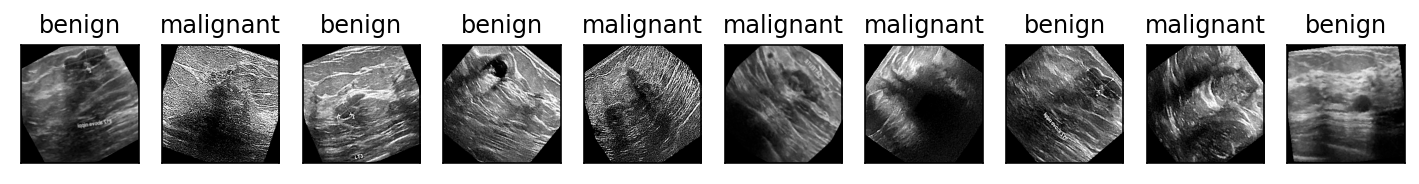

In [14]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 20, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

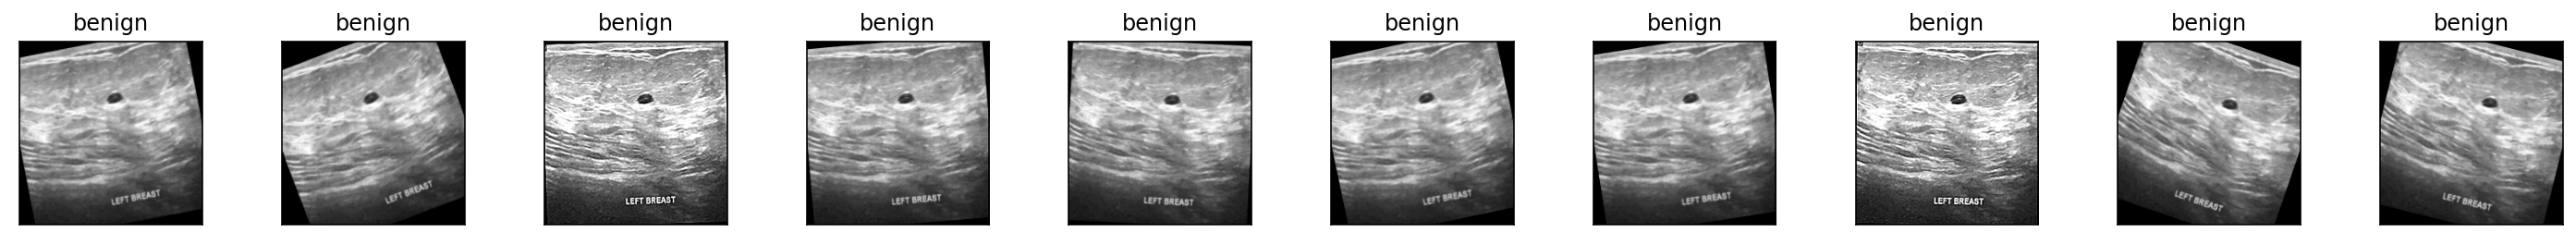

In [15]:
images, labels = next(iter(test_loader))
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [16]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 48, 3, padding =1)
        self.conv4 = nn.Conv2d(48, 64, 3, padding =1)
        
        self.pool1 = nn.MaxPool2d(4,4)
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(7*7*64, 922)
        self.fc2 = nn.Linear(922, 2)
        
        self.dropout = nn.Dropout(p= 0.25)
        self.batchn1 = nn.BatchNorm2d(16)
        self.batchn2 = nn.BatchNorm2d(32)
        self.batchn3 = nn.BatchNorm2d(48)
        self.batchn4 = nn.BatchNorm2d(64)
        
        
    def forward(self, x):
        
        x = self.pool1(F.relu(self.batchn1(self.conv1(x))))
        x = self.pool2(F.relu(self.batchn2(self.conv2(x))))
        x = self.pool2(F.relu(self.batchn3(self.conv3(x))))
        x = self.pool2(F.relu(self.batchn4(self.conv4(x))))

        x = torch.flatten(x, 1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.log_softmax(self.fc2(x), dim = 1)
        
        return x

In [17]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr= 0.0005)

In [18]:
print(model)

Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=922, bias=True)
  (fc2): Linear(in_features=922, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (batchn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet

class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes=2, model_name='efficientnet-b0'):
        super(EfficientNetClassifier, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained(model_name)
        
        # Modify the classifier layer for your specific number of classes
        in_features = self.efficientnet._fc.in_features
        self.efficientnet._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.efficientnet(x)

# Choose the EfficientNet variant you want (e.g., 'efficientnet-b0', 'efficientnet-b1', etc.)
model_efficientnet = EfficientNetClassifier(model_name='efficientnet-b0')
optimizer_efficientnet = optim.SGD(model_efficientnet.efficientnet._fc.parameters(), lr=0.0005)
criterion_efficientnet = nn.CrossEntropyLoss()


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\ajeet/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:06<00:00, 3.42MB/s]


Loaded pretrained weights for efficientnet-b0


In [20]:
epochs = 50

valid_loss_min = np.Inf
train_accuracy, val_accuracy = [], []
train_loss_list, val_loss_list = [], []


for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    t_acc = 0.0
    
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        train_loss += loss.item() * images.size(0)
        ps = torch.exp(logits)
        top_k, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        t_acc += equals.sum().item()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        model.eval()
        v_acc = 0.0
        for images, labels in valid_loader:
            logits = model(images)
            loss = criterion(logits, labels)
            valid_loss += loss.item() * images.size(0)
            ps = torch.exp(logits)
            top_k, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            v_acc += equals.sum().item()
        
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    train_loss_list.append(train_loss)
    val_loss_list.append(valid_loss)
    train_accuracy.append(t_acc / len(train_loader.sampler))
    val_accuracy.append(v_acc / len(valid_loader.sampler))
    
    print("Epoch ", epoch+1, "train loss ", train_loss, "validation loss ", valid_loss)
    
    if valid_loss <= valid_loss_min:
        print("validation loss decreased", valid_loss_min, "---->", valid_loss)
        print("Saving the model")
        torch.save(model.state_dict(), "model_googlenet.pt")
        valid_loss_min = valid_loss

Epoch  1 train loss  0.6546551739877606 validation loss  0.6149779322774632
validation loss decreased inf ----> 0.6149779322774632
Saving the model
Epoch  2 train loss  0.5884004799460072 validation loss  0.5722829502486771
validation loss decreased 0.6149779322774632 ----> 0.5722829502486771
Saving the model
Epoch  3 train loss  0.5584406396943543 validation loss  0.5464219599962234
validation loss decreased 0.5722829502486771 ----> 0.5464219599962234
Saving the model
Epoch  4 train loss  0.5334502509428654 validation loss  0.5296137638468105
validation loss decreased 0.5464219599962234 ----> 0.5296137638468105
Saving the model
Epoch  5 train loss  0.5233073050594286 validation loss  0.5155832590931224
validation loss decreased 0.5296137638468105 ----> 0.5155832590931224
Saving the model
Epoch  6 train loss  0.5001484559016696 validation loss  0.5045969415724608
validation loss decreased 0.5155832590931224 ----> 0.5045969415724608
Saving the model
Epoch  7 train loss  0.49191443994124

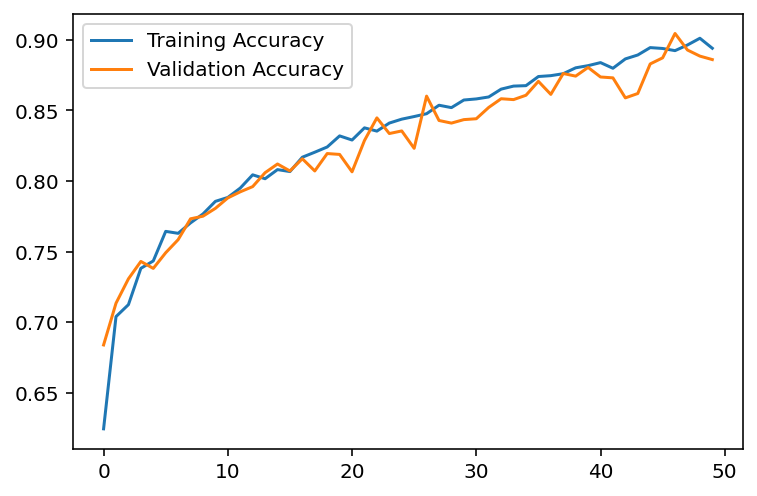

In [21]:
plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.legend()

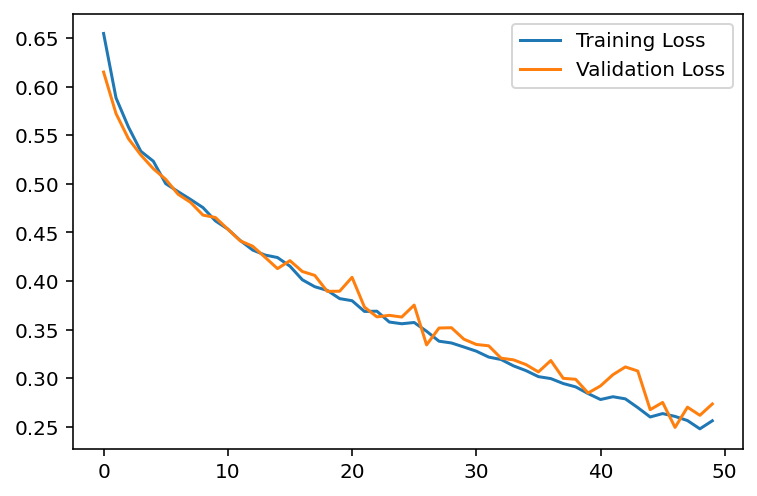

In [22]:
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.show()

In [23]:
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()

for data, target in test_loader:

    output = model(data)
    loss = criterion(output, target)

    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)  
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) 
    for i in range(len(target)):

        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.257090

Test Accuracy of benign: 95% (477/500)
Test Accuracy of malignant: 81% (325/400)

Test Accuracy (Overall): 89% (802/900)


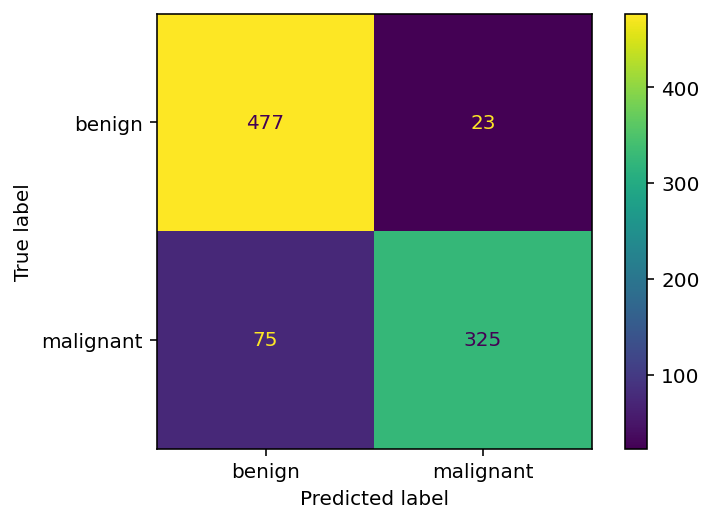

In [24]:
target = []
predictions = []
model.eval()
with torch.no_grad():
    for data, label in test_loader:
        logits = model(data)
        logits = (torch.max(torch.exp(logits), 1)[1]).data.numpy()
        predictions.extend(logits)
        label = label.data.numpy()
        target.extend(label)
cm = confusion_matrix(target, predictions)
dis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
dis.plot()
plt.show()

In [25]:
print(classification_report(target, predictions, target_names=classes))

              precision    recall  f1-score   support

      benign       0.86      0.95      0.91       500
   malignant       0.93      0.81      0.87       400

    accuracy                           0.89       900
   macro avg       0.90      0.88      0.89       900
weighted avg       0.90      0.89      0.89       900



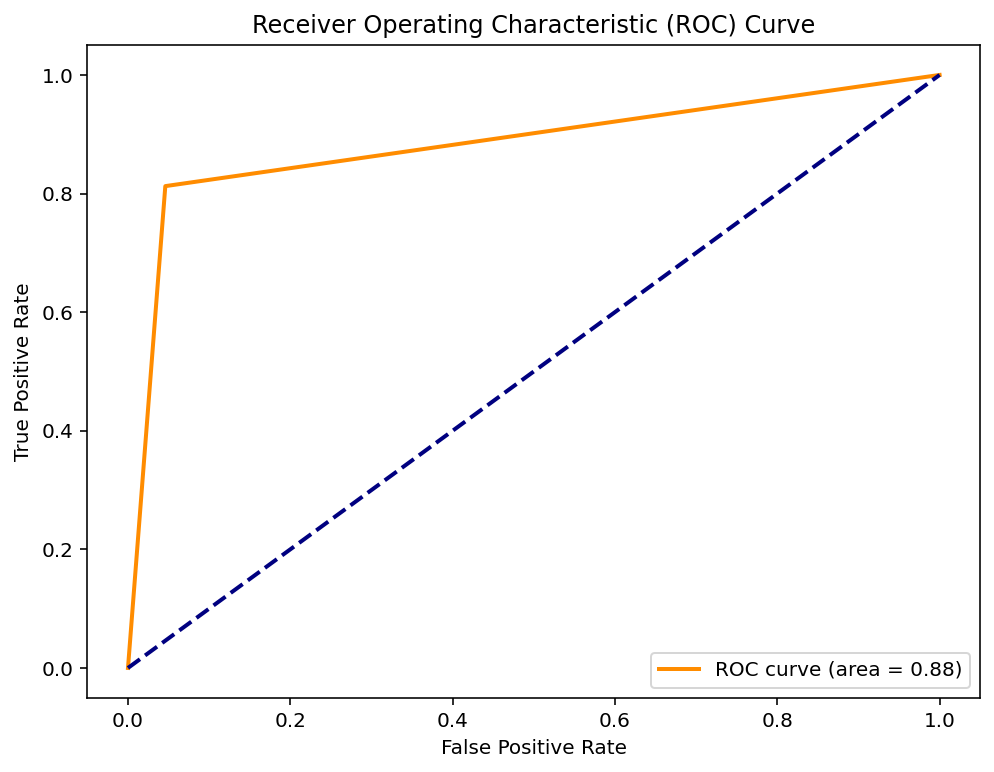

In [26]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(target, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
